import of lib


In [53]:
import numpy as np 
import pandas as pd 
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn .neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score , classification_report , roc_auc_score , roc_curve
import matplotlib.pyplot as plt 
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

Dataset Cleanup

Remove Rows

In [2]:
df = pd.read_csv("star_classification.csv")

# Affichage du nombre de valeurs manquantes par colonne
print(df.isnull().sum())

# Suppression des lignes avec des valeurs manquantes
df_cleaned = df.dropna()

 

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64


Suppression des doublons

In [16]:
print("Nombre de doublons :", df.duplicated().sum())

# Suppression des doublons
df_no_duplicates = df.drop_duplicates()

Nombre de doublons : 0


In [4]:
import numpy as np

df.replace(-9999, np.nan, inplace=True)


In [7]:
print(df.isna().sum())


obj_ID         0
alpha          0
delta          0
u              1
g              1
r              0
i              0
z              1
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64


visualisation de data

In [6]:
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)


             obj_ID       alpha     delta   u   g        r         i   z  \
79543  1.237649e+18  224.006526 -0.624304 NaN NaN  18.1656  18.01675 NaN   

       run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID class  redshift  \
79543     752       301        2       537  3.731277e+18  STAR  0.000089   

       plate    MJD  fiber_ID  
79543   3314  54970       162  


drop nulls 

In [8]:
df.dropna(inplace=True)


voir les types de colonnes et les nulls 

In [ ]:
print(df.describe())
print(df.info())   


             obj_ID         alpha         delta             u             g  \
count  9.999900e+04  99999.000000  99999.000000  99999.000000  99999.000000   
mean   1.237665e+18    177.628653     24.135552     22.080679     20.631583   
std    8.438450e+12     96.502612     19.644608      2.251068      2.037384   
min    1.237646e+18      0.005528    -18.785328     10.996230     10.498200   
25%    1.237659e+18    127.517698      5.147477     20.352410     18.965240   
50%    1.237663e+18    180.900527     23.646462     22.179140     21.099930   
75%    1.237668e+18    233.895005     39.901582     23.687480     22.123775   
max    1.237681e+18    359.999810     83.000519     32.781390     31.602240   

                  r             i             z        run_ID  rerun_ID  \
count  99999.000000  99999.000000  99999.000000  99999.000000   99999.0   
mean      19.645777     19.084865     18.768988   4481.403354     301.0   
std        1.854763      1.757900      1.765982   1964.739021  

plot the data distrubution , its in comment if you wanna see it remove the comment

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include='number').columns
'''
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution de {col}")
    #plt.show()


'''


'\nfor col in num_cols:\n    plt.figure(figsize=(6, 4))\n    sns.histplot(df[col], kde=True)\n    plt.title(f"Distribution de {col}")\n    #plt.show()\n\n\n'

split X and Y , we have 17 features and the class class 

In [10]:
X = df.drop(columns=["class"])
Y = df["class"]

In [43]:
print(X.shape)

(99999, 17)


In [44]:
print(Y.shape)

(99999,)


split 70/30 test and train 

In [54]:
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
Xt, Xtt, Yt, Ytt = train_test_split(
      scaled_features, Y, test_size = 0.30)

from tp2 evaluate the models 

In [22]:
def evaluate_model(model,X_test,Y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test,y_pred)
    y_proba = model.predict_proba(X_test)
    roc_auc = roc_auc_score(Y_test, y_proba, multi_class='ovr', average='macro')
    print(f"Accuracy: {accuracy:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print("Classification Report:")
    print(classification_report(Y_test, y_pred))

roc curve for multiclass also from tp1

In [50]:
from sklearn.metrics import auc


def compute_roc(y_true_bin, y_pred_prob):
    """
    Computes TPR and FPR at different thresholds for a given class.
    
    Parameters:
        y_true_bin (array-like): Binarized ground-truth labels (n_samples,)
        y_pred_prob (array-like): Predicted probabilities for the class (n_samples,)
        
    Returns:
        fpr_values (list): False Positive Rate values
        tpr_values (list): True Positive Rate values
        auc_value (float): Computed AUC score
    """
    # Get unique thresholds from predicted probabilities
    thresholds = np.unique(y_pred_prob)
    
    # Initialize TPR and FPR lists
    tpr_values = []
    fpr_values = []
    
    for threshold in thresholds:
        # Convert probabilities to binary classification (1 if greater than threshold, else 0)
        y_pred_binary = (y_pred_prob >= threshold).astype(int)

        # Compute TP, FP, FN, TN
        TP = np.sum((y_pred_binary == 1) & (y_true_bin == 1))
        FP = np.sum((y_pred_binary == 1) & (y_true_bin == 0))
        FN = np.sum((y_pred_binary == 0) & (y_true_bin == 1))
        TN = np.sum((y_pred_binary == 0) & (y_true_bin == 0))

        # Compute TPR and FPR
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        # Store values
        tpr_values.append(TPR)
        fpr_values.append(FPR)

    # Sort the values (ROC curve should be sorted in increasing FPR order)
    fpr_values, tpr_values = zip(*sorted(zip(fpr_values, tpr_values)))

    # Compute AUC using Trapezoidal Rule
    auc_value = auc(fpr_values, tpr_values)
    
    return list(fpr_values), list(tpr_values), auc_value

In [51]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

 

def plot_multiclass_roc_manual(y_true, y_score):
    class_names = np.unique(y_true)
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=class_names)

    colors = cycle(['blue', 'red', 'green'])

    plt.figure(figsize=(8, 6))

    for i, (class_name, color) in enumerate(zip(class_names, colors)):
        fpr, tpr, auc_score = compute_roc(y_true_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{class_name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Manual ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

K-NN classification 

In [ ]:
# implement the k-NN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Xt, Yt)
Yp = knn.predict(Xtt)
Yp_proba = knn.predict_proba(Xtt)

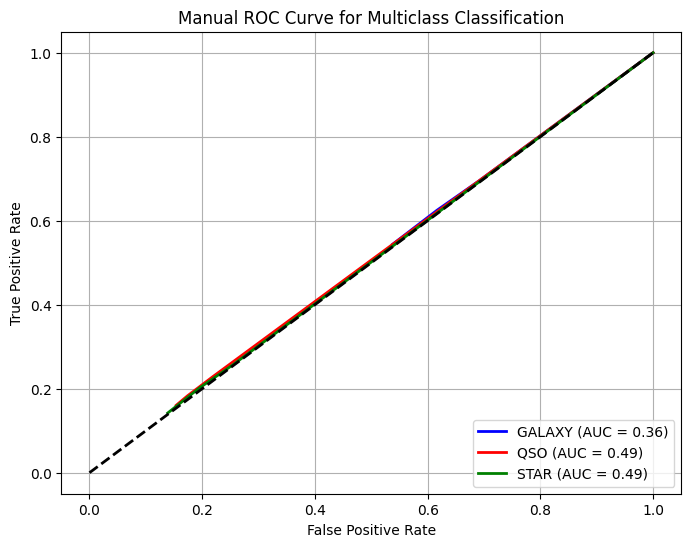

In [56]:
plot_multiclass_roc_manual(Ytt, Yp_proba)

Decision TREE

In [57]:
#1 Decision Tree 
#print("Decision_Tree")
dt_model = DecisionTreeClassifier(max_depth=5,random_state=42 )
dt_model.fit(Xt,Yt)
#evaluate_model(dt_model,X_test,Y_test)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [60]:
 
 
y_pred_dt = dt_model.predict(Xtt)
Yp_proba_dt = dt_model.predict_proba(Xtt)
print(f"Accuracy :{accuracy_score(Ytt,y_pred_dt):.2f}")
print('classificiation report ')
print(classification_report(Ytt,y_pred_dt))

Accuracy :0.97
classificiation report 
              precision    recall  f1-score   support

      GALAXY       0.96      0.99      0.97     17812
         QSO       0.96      0.87      0.91      5663
        STAR       1.00      1.00      1.00      6525

    accuracy                           0.97     30000
   macro avg       0.97      0.95      0.96     30000
weighted avg       0.97      0.97      0.97     30000



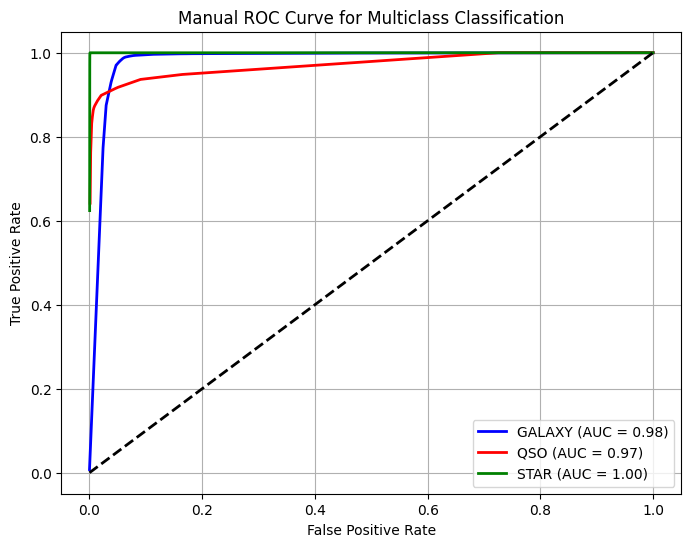

In [61]:
plot_multiclass_roc_manual(Ytt, Yp_proba_dt)

Transform data from sTring to int for XGB 

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels into integers
le = LabelEncoder()
Yt_encoded = le.fit_transform(Yt)   
Y_test_encoded = le.transform(Ytt)  # 


In [65]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(Xt, Yt_encoded)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [67]:
Ytt_encoded = le.transform(Ytt)
y_pred_XGB = xgb_model.predict(Xtt)
Yp_proba_XGB = dt_model.predict_proba(Xtt)
 
print(f"Accuracy :{accuracy_score(Ytt_encoded,y_pred_XGB):.2f}")
print('classificiation report ')
print(classification_report(Ytt_encoded,y_pred_XGB))


Accuracy :0.98
classificiation report 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     17812
           1       0.97      0.94      0.95      5663
           2       0.99      0.99      0.99      6525

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000



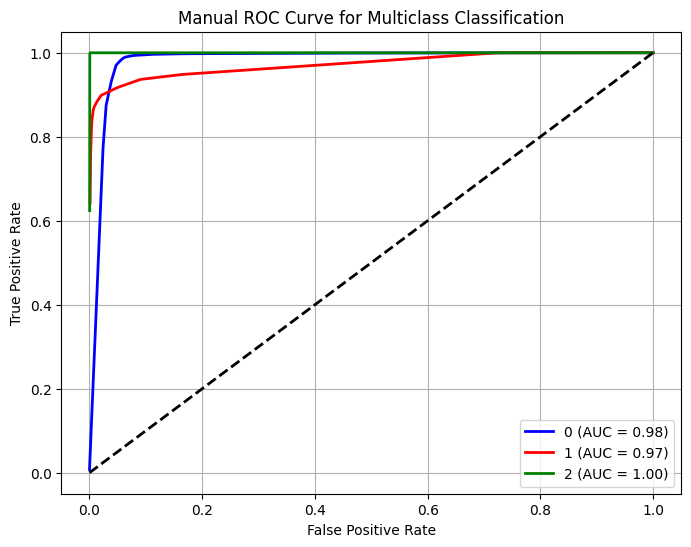

In [68]:
plot_multiclass_roc_manual(Ytt_encoded, Yp_proba_dt)